In [4]:
import Zygote: @ignore_derivatives
import CSV
import Plots
import Random
import Optimisers
import Zygote
import GLM
using DataFrames
using Lux
using JLD2
using Statistics
using Printf
using SciMLSensitivity
using DifferentialEquations
using StatsBase: sample
using ComponentArrays


include("../../../DCM/src/lib/population.jl");
include("../../../DCM/src/lib/model.jl");
include("../../../DCM/src/lib/error.jl");
include("../../../DCM/src/lib/objectives.jl");
include("../../../DCM/src/lib/compartment_models.jl");
include("../../../DCM/src/lib/callbacks.jl");
include("../../../DCM/src/lib/constrain.jl");
include("../../../DCM/src/lib/lux.helpers.jl");
include("../../../DCM/src/lib/dcm.jl");
include("../../../DCM/src/lib/nn.jl");
include("../../../DCM/src/lib/latent_encoder_decoder.jl");

basic_tgrad(u,p,t) = zero(u);

## Data preparation

In [5]:
# Read Data
file = "../../data/fviii_sim.csv"
df = CSV.read(file, DataFrame)

# One dataframe per patient
df_group = groupby(df, :id);

### Population for DNN (Interventions are covariates)

In [6]:
# Create population 
function create_population_dnn(df_group_inds)
    indvs = Vector{AbstractIndividual}(undef, length(df_group_inds))
    for (i, group) in enumerate(df_group_inds)
        x = Vector{Float32}(group[1, [:weight, :age, :amt]])
        ty = group[(group.mdv .== 0), [:t, :dv]]
        indvs[i] = Individual(x, Float32.(ty.t), Float32.(ty.dv), CallbackSet(); id = group.id[1])
    end
    return Population(indvs);
end

population_dnn = create_population_dnn(df_group);

### Population for Node and DCM (Interventions are callbacks)

In [7]:
# Create population
function create_population(df_group_inds)
    indvs = Vector{AbstractIndividual}(undef, length(df_group_inds))
    for (i, group) in enumerate(df_group_inds)
        x = Vector{Float32}(group[1, [:weight, :age]])
        ty = group[(group.mdv .== 0), [:t, :dv]]
        𝐈 = Matrix{Float32}(group[group.mdv .== 1, [:t, :amt, :rate, :duration]])
        callback = generate_dosing_callback(𝐈)
        indvs[i] = Individual(x, Float32.(ty.t), Float32.(ty.dv), callback; id = group.id[1])
    end
    return Population(indvs);
end
population = create_population(df_group);

## Load models

In [44]:
# DNN
mymodel = JLD2.load("../DNN/models/mymodel-fviii.jld2")
model_dnn = mymodel["model"];

In [9]:
# Encoder decoder
mymodel = JLD2.load("../EncDec/models/mymodel-fviii.jld2")
model_ed = mymodel["model"]
p_ed = mymodel["p"]
st_ed = mymodel["st"];

In [239]:
# Node
mymodel = JLD2.load("../NeuralODE/models/mymodel-fviii-5.jld2")
node = mymodel["node"]
p_node = mymodel["p_final"]
st_node = mymodel["st"];

In [11]:
# DCM
mymodel = JLD2.load("../DCM/models/mymodel-fviii.jld2")
model_dcm = mymodel["model"];

## Helper functions

### Helper functions for Node

In [12]:
# The function received by ODEFunction must have the form f(u, p, t; kwargs...).
# As the neural network receives [u; x] es inputs, we need to wrap the neural network on top of this function with the correct form.
# Additionally, we add the intervention as another parameter (will be used for the callbacks)
dudt(u, p, t; x, node, st) = node([u; x], p.weights, st)[1] + [p.I, 0.f0]

# Defines a method for the dudt function that accepts kwargs and calls the original dudt function with those arguments.
# The $ syntax (comes from PartialFunctions) is used to partially apply the function with the provided kwargs
dudt(; kwargs...) = dudt$(; kwargs...)

# Forward pass for one individual (solve the ODE)
function forward(model, individual::AbstractIndividual, p, st; dudt = dudt, get_dv::Bool=false, sensealg=nothing, full::Bool=false, interpolate::Bool=false, saveat_ = is_timevariable(individual) ? individual.t.y : individual.t)
    @ignore_derivatives p.I = zero(p.I)
    u0 = isempty(individual.initial) ? zeros(Float32, 2) : individual.initial
    saveat = interpolate ? empty(saveat_) : saveat_
    save_idxs = full ? (1:length(u0)) : 2
    
    f = dudt(; x = individual.x, node = model, st = st)
    ff = ODEFunction{false}(f; tgrad = basic_tgrad)
    prob = ODEProblem{false}(ff, u0, (-0.1f0, maximum(saveat_)), p)
    
    interpolate && (individual.callback.save_positions .= 1)
    sol = solve(prob, Tsit5(),
        save_idxs = save_idxs, saveat = saveat, callback=individual.callback, 
        tstops=individual.callback.condition.times, sensealg=sensealg
    )
    interpolate && (individual.callback.save_positions .= 0)
    return get_dv ? sol[2, :] : sol
end

# Forward pass for population. The Ref function "freezes" the parameters with respect to the dot operator
forward(model, population::Population, p, st; kwargs...) = forward.((model,), population, (p,), (st,); kwargs...)

forward (generic function with 7 methods)

### Helper function for EncoderDecoder

In [13]:
# The forward adjoint method is only defined for populations. Create one for individuals
function forward_ed(model, individual, p, st; kwargs...)
    popind = Population([individual])
    predicted = forward_adjoint(model, popind, p, st; kwargs...)[1]
    return predicted
end;

### Helper function to create callbacks

In [14]:
# Create Intervention Matrix from [(time1, dose1), (time2, dose2), ...] list
function create_intervention_matrix(dose_list; duration = 120)
    if length(dose_list) == 0 return end
    M = []
    for (t, d) in dose_list
        row = [t, d, d * duration, 1/duration]
        push!(M, row)
    end

    # Convert the array of arrays to a matrix
    M = hcat(M...)
    M = M'
end;

## Predict functions

In [15]:
# DNN
predict_dnn(individual, model) = predict(model, individual)[1]

# Encoder decoder
predict_ed(individual, model, p, st) = forward_ed(model, individual, p, st)

# Node
predict_node(individual, node, p, st) = forward(node, individual, ComponentVector(merge(p, (I = 0.f0, ))), st; interpolate = false).u

# DCM
predict_dcm(individual, model) = predict(model, individual; interpolate=false)[1].u;


In [16]:
# Create an individual with dose as callback based on an individual with dose as covariate
function create_individual_callback(individual_dnn)
    doses = [(0,individual_dnn.x[end])] # (Time, Dose)
    I = create_intervention_matrix(doses)
    callback = generate_dosing_callback(I)
    ind = Individual(Float32.(individual_dnn.x[1:end-1]), Float32.(individual_dnn.t), Float32.(zeros(length(individual_dnn.t))), callback)
    return ind
end

# Function to plot the predictions of the 4 models simultaneously
function predict_all(individual_dnn, individual)
    y_dnn = predict_dnn(individual_dnn, model_dnn)
    y_ed = predict_ed(individual, model_ed, p_ed, st_ed)
    y_node = predict_node(individual, node, p_node, st_node)
    y_dcm = predict_dcm(individual, model_dcm);

    plt = Plots.plot(xlabel="Time", ylabel="Concentration", size=(600,300))
    Plots.plot!(plt, individual.t, y_dnn, label="DNN", color = :black, linewidth=1)
    Plots.plot!(plt, individual.t, y_ed, label="ED", color = :black, linewidth=1, linestyle=:dash)
    Plots.plot!(plt, individual.t, y_node, label="NODE", color = :gray, linewidth=1)
    Plots.plot!(plt, individual.t, y_dcm, label="DCM", color = :gray, linewidth=1, linestyle=:dash)

    return plt
end;

## Predict with labels

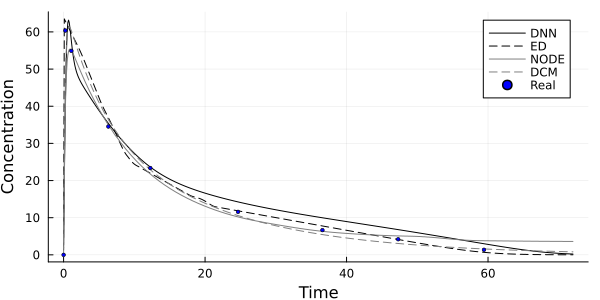

In [240]:
id = 2
time_labels = population[id].t
labels = population[id].y;

# An artificial individual must be created in order to predict "continuously" over time
t = collect(0:0.1:72)
ind_dnn = Individual(Float32.(copy(population_dnn[id].x)), Float32.(t), Float32.(zeros(length(t))), CallbackSet());
ind = create_individual_callback(ind_dnn)
plt = predict_all(ind_dnn, ind)
Plots.scatter!(plt, time_labels, labels, markersize=2, color=:blue, label = "Real")

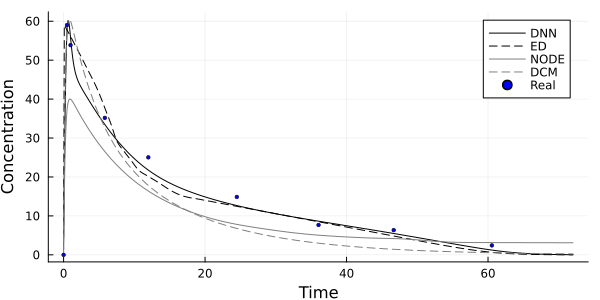

In [228]:
id = 1
time_labels = population[id].t
labels = population[id].y;

# An artificial individual must be created in order to predict "continuously" over time
t = collect(0:0.1:72)
ind_dnn = Individual(Float32.(copy(population_dnn[id].x)), Float32.(t), Float32.(zeros(length(t))), CallbackSet());
ind = create_individual_callback(ind_dnn)
plt = predict_all(ind_dnn, ind)
Plots.scatter!(plt, time_labels, labels, markersize=2, color=:blue, label = "Real")

## Experiment functions

### Functions

In [20]:
function test_variable(ind; variable="AMT", values=[0, 1, 10, 50, 100, 200, 500], modeltype="dnn", show_legend=true, palette=(:grays, length(values)+1))
    colors = Plots.palette(palette[1], palette[2])

    cback = ind.callback
    x = copy(ind.x)
    t = copy(ind.t)

    plt = Plots.plot(legend=show_legend)
    for (i, val) in enumerate(values)
        if variable == "AMT"
            if modeltype ==  "dnn"
                x[3] = val
            else
                I = create_intervention_matrix([(0.0, val)])
                cback = generate_dosing_callback(I)
            end
        elseif variable == "WEIGHT"
            x[1] = val
        elseif variable == "AGE"
            x[2] = val
        else
            error("Variable not found")
        end

        test_ind = Individual(Float32.(x), Float32.(ind.t), Float32.(zeros(length(t))), cback)

        if modeltype == "dnn"
            predicted = predict_dnn(test_ind, model_dnn)
        elseif modeltype == "node"
            predicted = predict_node(test_ind, node, p_node, st_node)
        elseif modeltype == "dcm"
            predicted =  predict_dcm(test_ind, model_dcm)
        elseif modeltype == "ed"
            predicted = predict_ed(test_ind, model_ed, p_ed, st_ed)

        else
            error("Unkwnown model type")
        end
        plt = Plots.plot!(test_ind.t, predicted, linewidth=1, label="$variable=$val", linecolor=colors[i], title=uppercase(modeltype))
    end
    return plt
end;

function test_models(individual_dnn, variable, vals)
    # Create individual for the models that use dose as callback
    ind = create_individual_callback(individual_dnn)

    plt_dnn = test_variable(ind_dnn; variable=variable, values=vals, modeltype="dnn", show_legend=false);
    plt_ed = test_variable(ind; variable=variable, values=vals, modeltype="ed", show_legend=false);
    plt_node = test_variable(ind; variable=variable, values=vals, modeltype="node", show_legend=false);
    plt_dcm = test_variable(ind; variable=variable, values=vals, modeltype="dcm", show_legend=true);
    Plots.plot(plt_dnn, plt_ed, plt_node, plt_dcm, layout=(2,2), size=(800,400))
end

test_models (generic function with 1 method)

### Initialize individual

In [217]:
t = collect(0:0.1:72)
x = [70.0, 40.0, 25*70]

ind_dnn = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), CallbackSet());
ind = create_individual_callback(ind_dnn)

BasicIndividual{id = , ...)

### Change variable

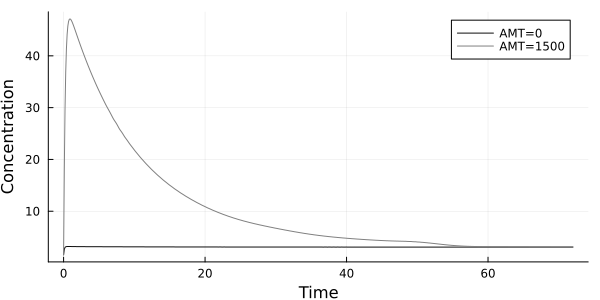

In [230]:
variable = "AMT" #"WEIGHT"
vals = [0, 1500] 

#variable = "WEIGHT"
#vals = [30, 50, 70, 100, 150]

#plt = test_variable(ind_dnn; variable=variable, values=vals, modeltype="dnn", show_legend=true);
#plt = test_variable(ind; variable=variable, values=vals, modeltype="ed", show_legend=true);
plt = test_variable(ind; variable=variable, values=vals, modeltype="node", show_legend=true);
#plt = test_variable(ind; variable=variable, values=vals, modeltype="dcm", show_legend=true);
Plots.plot(plt, size=(600,300), title="", xlabel="Time", ylabel="Concentration")

### Simulate long time

Last value: 2.8945262


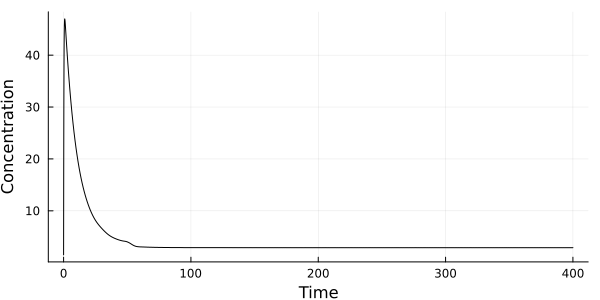

In [225]:
t = collect(0:0.1:400)
x = [70.0, 40.0, 1500]

ind_dnn = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), CallbackSet());

doses = [(0,1500)] # (Time, Dose)
I = create_intervention_matrix(doses)
callback = generate_dosing_callback(I)

ind = Individual(Float32.(x[1:end-1]), Float32.(t), Float32.(zeros(length(t))), callback);

#y = predict_dnn(ind_dnn, model_dnn)
#y = predict_ed(ind, model_ed, p_ed, st_ed)
y = predict_node(ind, node, p_node, st_node)
#y = predict_dcm(ind, model_dcm);

println("Last value: $(y[end])")

Plots.plot(ind.t, y, color = :black, linewidth=1, size=(600,300), title="", xlabel="Time", ylabel="Concentration", label="")


## Multiple doses

### Functions

In [167]:
# For DNNs, when giving multiple doses, we need to treat it as addition. So we predict first a dose, and then add the new one
function multiple_doses_dnn(model, ind, doses; timestep = 0.1) #[(time, dose),...]
    x = copy(ind.x)
    predicted_final = zeros(length(ind.t))

    for dose in doses
        x[end] = dose[2]
        ind_dnn = Individual(Float32.(x), Float32.(ind.t), Float32.(zeros(length(ind.t))), CallbackSet());
        predicted = predict_dnn(ind_dnn, model)
    
        start_time_ix = findfirst(x -> x == dose[1], ind.t)
        end_time_ix = length(t) - start_time_ix + 1
    
        predicted_final[start_time_ix:end] .+= predicted[1:end_time_ix]
    end
    return predicted_final
end;

# Doses must be a list of tuples [(time, dose, duration), (...)]. If duration = 0, it is assumed it is a bolus dose wit duration_bolus
function multiple_doses_all(ind, doses; duration_bolus = 1/120)
    timestep = ind.t[2] - ind.t[1]
    t = copy(ind.t)
    x = copy(ind.x)

    dosing = []
    I = zeros(1,4)
    for dose in doses
        if dose[3] == 0 # Bolus
            dosing_tmp = [(dose[1], dose[2])]

            # Define duration of dose for the other models
            duration = duration_bolus
        else # Infusion
            # Discretize dosing regime for DNN when infusion
            # To simulate an infusion with the DNN, we need to do something more complex, as it does not use callbacks for the doses. The DNN is, additionally, discrete in its predictions, so we can model an infusion as multiple quick and small bolus doses during the time we want the infusion to happen. Suppose we want an infusion of dose D that starts at time t0 and has duration T. If we discretize the time between t0 and T in k timesteps, then at each timestep we can simulate a bolus dose of D/k.
            k = (dose[3] - dose[1])/timestep
            dosing_tmp = [(i, dose[2]/k) for i in dose[1]:timestep:dose[1] + dose[3]][1:end-1] # There is no dose in the last timestep
            # Define duration of dose for the other models
            duration = dose[3]
        end
        dosing = vcat(dosing, dosing_tmp)
        intervention = [dose[1] dose[2] dose[2]/duration duration]
        I = vcat(I, intervention)
    end
    I = I[2:end, :] # First row was the initialization row and must be discarded
    callback = generate_dosing_callback(I)
    
    ind_dnn = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), CallbackSet());
    ind = Individual(Float32.(x[1:end-1]), Float32.(t), Float32.(zeros(length(t))), callback);
    
    predicted_dnn = multiple_doses_dnn(model_dnn, ind_dnn, dosing)
    predicted_ed = predict_ed(ind, model_ed, p_ed, st_ed)
    predicted_node = predict_node(ind, node, p_node, st_node)
    predicted_dcm = predict_dcm(ind, model_dcm);

    return predicted_dnn, predicted_ed, predicted_node, predicted_dcm
end;

### Simulate multiple doses

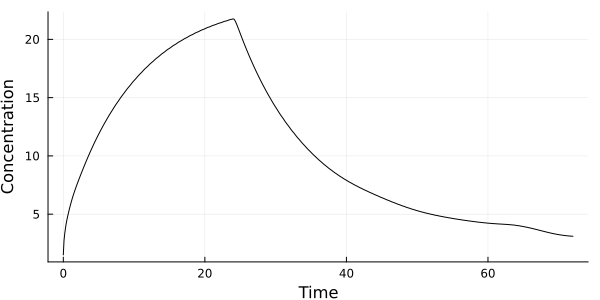

In [227]:
timestep = 0.1
t = collect(0:timestep:72)
x = [70.0, 40.0, 0]
ind = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), CallbackSet());
#doses = [(0, 1500, 0), (12, 1500, 0), (24, 1500, 0), (36, 1500, 0)]  # Multiple Bolus
#doses = [(0, 1500, 0), (12, 0, 0), (24, 0, 0), (36, 0, 0)] # Bolus followed by zero doses
doses = [(0, 1500, 24)]  # Infusion
#doses = [(0, 1500, 0), (24, 1500, 12), (48, 1500, 0)]  # Bolus, infusion, bolus

predicted_dnn, predicted_ed, predicted_node, predicted_dcm = multiple_doses_all(ind, doses)

plt = Plots.scatter(size=(600,300))
#Plots.plot!(plt, t, predicted_dnn, color = :black, linewidth=1, xlabel="Time", ylabel="Concentration", label = nothing)
#Plots.plot!(plt, t, predicted_ed,  color = :black, linewidth=1, xlabel="Time", ylabel="Concentration", label = nothing)
Plots.plot!(plt, t, predicted_node, color = :black, linewidth=1, xlabel="Time", ylabel="Concentration", label = nothing)
#Plots.plot!(plt, t, predicted_dcm,  color = :black, linewidth=1, xlabel="Time", ylabel="Concentration", label = nothing)

### Simulate initial dose followed by 0 doses

### Infusion
Infusion refers to the slow continuous administration of the drug at a constant rate

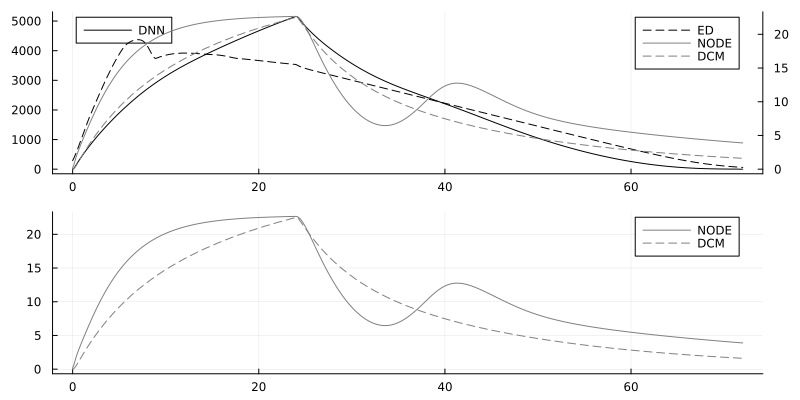

In [106]:
t = collect(0:timestep:72)
x = [70.0, 40.0, 0]
ind = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), CallbackSet());
doses = [(0, 1500, 24)] 

predicted_dnn, predicted_ed, predicted_node, predicted_dcm = multiple_doses_all(ind, doses)

# All the plots combined with DNN on different axis for scale. DNN on the left axis because its scale is too large. This happens because for the DNN an infusion scheme is modeled as multiple low-bolus injections. As the DNN gives response for even dose=0, then all the responses add up an the final values are very large.
plt = Plots.plot()
plt_twin = Plots.twinx(plt)
Plots.plot!(plt, t, predicted_dnn, label="DNN", color = :black, linewidth=1, legend=:topleft)
Plots.plot!(plt_twin, t, predicted_ed, label="ED", color = :black, linewidth=1, linestyle=:dash)
Plots.plot!(plt_twin, t, predicted_node, label="NODE", color = :gray, linewidth=1)
Plots.plot!(plt_twin, t, predicted_dcm, label="DCM", color = :gray, linewidth=1, linestyle=:dash, legend=:topright)

# Only Node and DCM to better perceive them due to the large scale of ED
plt2 = Plots.plot()
Plots.plot!(plt2, t, predicted_node, label="NODE", color = :gray, linewidth=1)
Plots.plot!(plt2, t, predicted_dcm, label="DCM", color = :gray, linewidth=1, linestyle=:dash)

Plots.plot(plt, plt2, layout=(2,1), size=(800,400))

###  Bolus + Infusion + Bolus

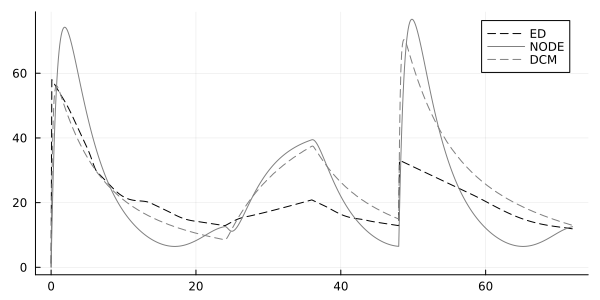

In [107]:
t = collect(0:timestep:72)
x = [70.0, 40.0, 0]
ind = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), CallbackSet());
doses = [(0, 1500, 0), (24, 1500, 12), (48, 1500, 0)] 

predicted_dnn, predicted_ed, predicted_node, predicted_dcm = multiple_doses_all(ind, doses)

plt = Plots.scatter(size=(600,300))
# Plots.plot!(plt, t, predicted_dnn, label="DNN", color = :black, linewidth=1) #  DNN not shown due to scale
Plots.plot!(plt, t, predicted_ed, label="ED", color = :black, linewidth=1, linestyle=:dash)
Plots.plot!(plt, t, predicted_node, label="NODE", color = :gray, linewidth=1)
Plots.plot!(plt, t, predicted_dcm, label="DCM", color = :gray, linewidth=1, linestyle=:dash)

### Infusion + Bolus +  Bolus

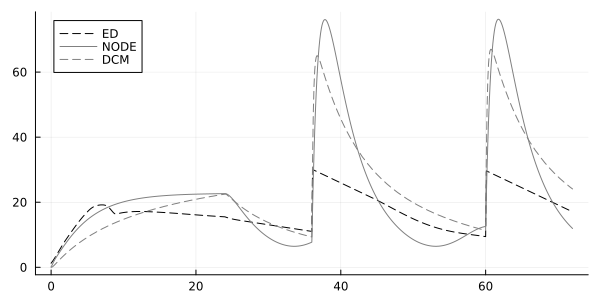

In [108]:
t = collect(0:timestep:72)
x = [70.0, 40.0, 0]
ind = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), CallbackSet());
doses = [(0, 1500, 24), (36, 1500, 0), (60, 1500, 0)] 

predicted_dnn, predicted_ed, predicted_node, predicted_dcm = multiple_doses_all(ind, doses)

plt = Plots.scatter(size=(600,300))
# Plots.plot!(plt, t, predicted_dnn, label="DNN", color = :black, linewidth=1) #  DNN not shown due to scale
Plots.plot!(plt, t, predicted_ed, label="ED", color = :black, linewidth=1, linestyle=:dash)
Plots.plot!(plt, t, predicted_node, label="NODE", color = :gray, linewidth=1)
Plots.plot!(plt, t, predicted_dcm, label="DCM", color = :gray, linewidth=1, linestyle=:dash)

### Infusion + Bolus

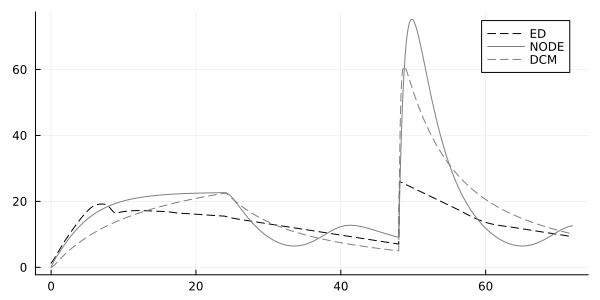

In [109]:
t = collect(0:timestep:72)
x = [70.0, 40.0, 0]
ind = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), CallbackSet());
doses = [(0, 1500, 24), (48, 1500, 0)] 

predicted_dnn, predicted_ed, predicted_node, predicted_dcm = multiple_doses_all(ind, doses)

plt = Plots.scatter(size=(600,300))
# Plots.plot!(plt, t, predicted_dnn, label="DNN", color = :black, linewidth=1) #  DNN not shown due to scale
Plots.plot!(plt, t, predicted_ed, label="ED", color = :black, linewidth=1, linestyle=:dash)
Plots.plot!(plt, t, predicted_node, label="NODE", color = :gray, linewidth=1)
Plots.plot!(plt, t, predicted_dcm, label="DCM", color = :gray, linewidth=1, linestyle=:dash)

### Bolus + infusion

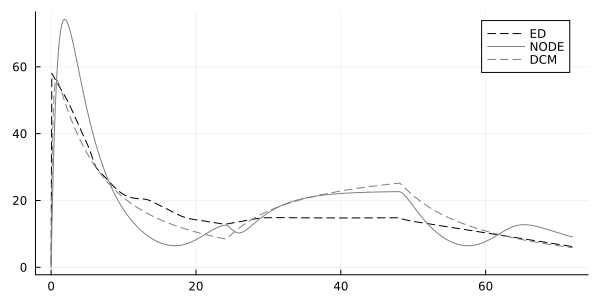

In [110]:
t = collect(0:timestep:72)
x = [70.0, 40.0, 0]
ind = Individual(Float32.(x), Float32.(t), Float32.(zeros(length(t))), CallbackSet());
doses = [(0, 1500, 0), (24, 1500, 24)] 

predicted_dnn, predicted_ed, predicted_node, predicted_dcm = multiple_doses_all(ind, doses)

plt = Plots.scatter(size=(600,300))
# Plots.plot!(plt, t, predicted_dnn, label="DNN", color = :black, linewidth=1) #  DNN not shown due to scale
Plots.plot!(plt, t, predicted_ed, label="ED", color = :black, linewidth=1, linestyle=:dash)
Plots.plot!(plt, t, predicted_node, label="NODE", color = :gray, linewidth=1)
Plots.plot!(plt, t, predicted_dcm, label="DCM", color = :gray, linewidth=1, linestyle=:dash)